In [1]:
!pip install transformers scikit-learn pandas --quiet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')
df.head()

/tmp/ipython-input-3-655650363.py:2: ParserWarning: Skipping line 213097: unexpected end of data

  df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape
df = df.sample(15000)

In [5]:
df= df[['Text', 'Score']].dropna()
df = df[df['Score'] !=3 ]
df['label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

In [6]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Text'], df['label'], test_size=0.2, random_state=42)

In [7]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(list(train_texts), truncation = True, padding = True, max_length = 128)
val_encodings = tokenizer(list(val_texts), truncation= True, padding=True, max_length = 128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [8]:
import torch

class AmazonDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}
    def __len__(self):
        return len(self.labels)

train_dataset = AmazonDataset(train_encodings, list(train_labels))
val_dataset = AmazonDataset(val_encodings, list(val_labels))

In [9]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
import os, time

os.environ["WANDB_DISABLED"] = "true"  # Disable W&B tracking

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/RoBERTa_Sentiment/results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    logging_dir='/content/drive/MyDrive/RoBERTa_Sentiment/logs',
    logging_steps=10,
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [10]:
start_time = time.time()
trainer.train()
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss
1,0.196900,0.210633
2,0.114300,0.176345


Training time: 534.08 seconds


In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

start_test = time.time()
predictions = trainer.predict(val_dataset)
test_time = time.time() - start_test

y_pred = predictions.predictions.argmax(axis=-1)
y_true = val_labels

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Testing Time: {test_time:.2f} seconds")

Accuracy: 0.9515
Precision: 0.9726
Recall: 0.9701
F1 Score: 0.9714
Training Time: 534.08 seconds
Testing Time: 18.47 seconds


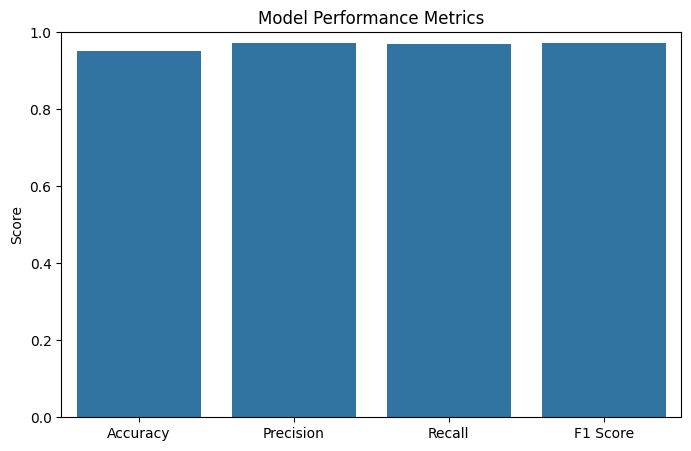

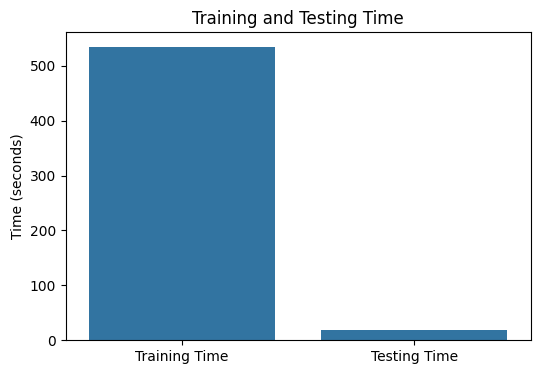

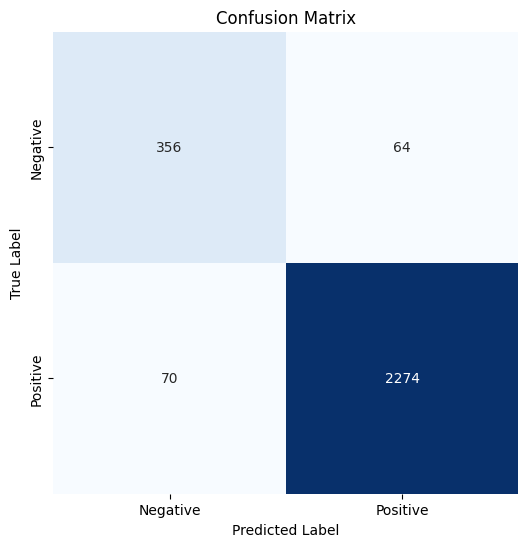

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualize results
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [acc, prec, rec, f1]

plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values)
plt.title('Model Performance Metrics')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.show()

# Visualize training and testing time
times = ['Training Time', 'Testing Time']
time_values = [training_time, test_time]

plt.figure(figsize=(6, 4))
sns.barplot(x=times, y=time_values)
plt.title('Training and Testing Time')
plt.ylabel('Time (seconds)')
plt.show()

# Visualize Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()